In [38]:
from PIL import Image
import os
import glob
import random
import csv
random.seed(4)
import json
import pandas as pd
import numpy as np
import tqdm
# Non propre A DELETE
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# ENDELETE
import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
import torch.nn.functional as func
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import albumentations as A
## A nettoyer
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## En evaluation
import helpers.engine as eng


In [3]:
### DEFINITION DES FONCTIONS ###
class ObjectDetectionDataset(Dataset):
    """
    Custom PyTorch Dataset Class to facilitate loading data for the Object Detection Task
    """
    def __init__(self, 
                 path_to_dataset,  
                 mapping = None, 
                 mode = 'train', 
                 transform = None): 
        """ 
        Args:
            annotations: The path to the annotations CSV file. Format: file_name, classes, xmin, ymin, xmax, ymax
            train_test_valid_split: The path to the tags CSV file for train, test, valid split. Format: file_name, tag
            mapping: a dictionary containing mapping of class name and class index. Format : {'class_name' : 'class_index'}, Default: None
            mode: Mode in which to instantiate class. Default: 'train'
            transform: The transforms to be applied to the image data

        Returns:
            image : Torch Tensor, target: Torch Tensor, file_name : str
        """
        self.mapping = mapping
        self.transform = transform
        self.mode = mode

        self.path_to_images = path_to_dataset
        # Loading the annotation file (same format as Remo's)
        
        #my_data = pd.read_csv(annotations)
        
        # Here we append the file path to the filename. 
        # If dataset.export_annotations_to_file was used to create the annotation file, it would feature by default image file paths
        
        #my_data['file_name'] = my_data['file_name'].apply(lambda x : os.path.abspath(f'{self.path_to_images}{x}'))
        #my_data = my_data.set_index('file_name')
        
        annotations_file_path = os.path.join(path_to_dataset, 'annotations.json')
        data = read_file(annotations_file_path)
        my_data  = extractDataSetFromCOCO(data,path_to_dataset)
        my_data['file_name'] = path_to_dataset +  my_data['file_name']
        # Loading the train/test split file (same format as Remo's)
        #my_data['tag'] = pd.read_csv(train_test_valid_split, index_col='file_name')
        
        #my_data = my_data.reset_index()
        # Load only Train/Test/Split depending on the mode
        #my_data = my_data.loc[my_data['tag'] == mode].reset_index(drop=True)
        self.data = my_data

        self.file_names = self.data['file_name'].unique()

    def __len__(self) -> int:
        return self.file_names.shape[0]

    def __getitem__(self, index: int):

        file_name = self.file_names[index]
        records = self.data[self.data['file_name'] == file_name].reset_index()       
        image = np.array(Image.open(file_name), dtype=np.float32)
        image /= 255.0

        if self.transform:
            image = self.transform(image)  

        # here we are assuming we don't have labels for the test set
        if self.mode != 'test':
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            if self.mapping is not None:
                labels = np.zeros((records.shape[0],))

                for i in range(records.shape[0]):
                    labels[i] = self.mapping[records.loc[i, 'classes']]

                labels = torch.as_tensor(labels, dtype=torch.int64)

            else:
                labels = torch.ones((records.shape[0],), dtype=torch.int64)

            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd 
            target['boxes'] = torch.stack(list((map(torch.tensor, target['boxes'])))).type(torch.float32)

            return image, target, file_name
        else:
            return image, file_name

def collate_fn(batch):
    return tuple(zip(*batch))

def read_file(path_to_file):
    # Read annotations
    with open(path_to_file, 'r') as f:
        dataset = json.loads(f.read())
    return dataset

def extractDataSetFromCOCO(dataset,imagePath):
    """ 
    Args:
        dataset : a parsed JSON file countaining the annotations, must be COCO format.
        imagePath : Path to a file with all the dataSet images.
    Returns:
        df : A pandas dataFrame with the annotations and the image file name
    """
    df = pd.DataFrame()
    categories = [row['name'] for row in dataset['categories']]
    images = [row['file_name'] for row in dataset['images']]
    df['classes'] = [row['category_id'] for row in dataset['annotations']]
    df['file_name'] = [row['image_id'] for row in dataset['annotations']]
    df['file_name'] = [images[i] for i in df['file_name']]
    df['classes'] = [categories[i] for i in df['classes']]
    ## A DELETE ALED
    #df['image'] = [ img_to_array(load_img(imagePath + '/' + fil, target_size=(224, 224))) for fil in df['file_name']] #Très sale, à voir pour faire mieux
    
    df['xmin'] = [row['bbox'][0] for row in dataset['annotations']]
    df['ymin'] = [row['bbox'][1] for row in dataset['annotations']]
    df['xmax'] = [row['bbox'][0]+row['bbox'][2] for row in dataset['annotations']]
    df['ymax'] = [row['bbox'][1]+row['bbox'][3] for row in dataset['annotations']]
    return df

def evaluate(data_loader,device,cat_to_index): 
    """ 
    Args:
        data_loader : A Pytorch dataloader with the images we want to perform detection on.
        device : A Pytorch device, CPU or GPU.
        cat_to_index : A dictionnary linking labels to a int.
    Returns:
        results : List of dictionnary with the bounding boxes, the labels and the scores. It can be easely saved as csv or json.
    """
    mapping = { value : key for (key, value) in cat_to_index.items()}
    detection_threshold = 0.3
    results = []
    model.eval()
    data_loader = tqdm.tqdm(data_loader)

    with torch.no_grad():
        for images, image_ids in data_loader:

            images = list(image.to(device) for image in images)
            outputs = model(images)
            for i, image in enumerate(images):

                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                scores = scores[scores >= detection_threshold]
                image_id = image_ids[i]

                for box, labels,score in zip(boxes, outputs[i]['labels'],scores):
                    results.append({'file_name' : os.path.basename(image_id), 
                                    'classes'   : mapping[labels.item()], 
                                    'xmin'      : box[0],
                                    'ymin'      : box[1],
                                    'xmax'      : box[2],
                                    'ymax'      : box[3],
                                    'scores'    : score})
    return results
        
def convert_points_to_box(points, color = 'red', alpha = 0.09):
    '''
        Helper Function : return two pyplot.Rectangle for the purpous of plotting bboxes. One is the border and one is the fill color.
    '''
    upper_left_point = (points[0], points[1])
    width = points[2] - points[0]
    height = points[3] - points[1]
    return (plt.Rectangle(upper_left_point, width, height, ec=color,fc=color, alpha=1,facecolor='none',fill = False),plt.Rectangle(upper_left_point, width, height, ec=color,fc=color, alpha=alpha))

def show_bounding_boxes(img,l_boxes,l_scores = None,labels = None,fontsize = 16):
    '''
        Show the bounding boxes in l_boxes for a specified image img in np.array format. 
    '''
    fig = plt.figure(figsize=(25, 10))
    colors = ['red','blue']
    ax = plt.gca()
    colors_idx = [random.randint(0, len(colors)-1) for i in l_boxes]
    plt.imshow(img)
    for i,box in enumerate(l_boxes):
        contour,texture = convert_points_to_box(box, colors[colors_idx[i]], 0.1)
        ax.add_patch(contour)
        ax.add_patch(texture)
        if labels and l_scores:
            plt.text(box[0],box[1],labels[i] + " : "+ str(np.round_(100*l_scores[i], decimals=2))+ " %",fontsize=fontsize,color =colors[colors_idx[i]] )

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.show()
    
def show_result(results,path_to_dataset,file_name):
    '''
        Show the bounding boxes in l_boxes for a specified image img in np.array format. 
    '''
    img = plt.imread(path_to_dataset + "/" + file_name)
    l_boxes = []
    l_labels = []
    l_scores = []
    for row in results:
        if row['file_name'] == file_name:
            l_boxes.append([row['xmin'],row['ymin'],row['xmax'],row['ymax']])
            l_labels.append(row['classes'])
            l_scores.append(row['scores'])
    print("Nombre de déchets identifiés : ", len(l_boxes))
    show_bounding_boxes(img,l_boxes,l_scores = l_scores,labels = l_labels)

In [4]:
### CONFIG ###

model_path = "../saved_models/model3SGD"
path_to_data = '../dataset/dataset_Trashedy_1.0/train/'
path_to_validation_data = '../dataset/dataset_Trashedy_1.0/valid/'
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cat_to_index = {'other': 1, 
                'pet': 2,
                'eps-polystyrene-': 3, 
                'plastic_bag' : 4 
                }
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 5
loss_value  = 0.0
num_epochs  = 1

In [5]:
### LOAD DATASET ###


tensor_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = ObjectDetectionDataset(path_to_dataset = path_to_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'train')

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

validation_dataset = ObjectDetectionDataset(path_to_dataset = path_to_validation_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'valid')

validation_data_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [6]:
### TELECHARGEMENT DU MODELE ###
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # IMPROVE WITH ADAM !
#optimizer = torch.optim.Adam(params, lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [60]:
### ENTRAINEMENT DU MODELE ###
l_losses = {'loss_classifier' : [],'loss_box_reg' : [],'loss_rpn_box_reg' : [],'loss_objectness':[]}
for epoch in range(num_epochs):

    train_data_loader = tqdm.tqdm(train_data_loader)
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        l_losses['loss_classifier'].append(loss_dict['loss_classifier'].item())
        l_losses['loss_box_reg'].append(loss_dict['loss_box_reg'].item())
        l_losses['loss_objectness'].append(loss_dict['loss_objectness'].item())
        l_losses['loss_rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].item())
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
    print('\nTraining Loss : {:.5f}'.format(loss_value))
    #eng.evaluate(model, validation_data_loader, device=device)
torch.save(model,"model3SGD")
print("Fin de l'entrainement, modele sauvegardé")


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [17:54<00:00, 13.60s/it]



Training Loss : 0.12650
Fin de l'entrainement, modele sauvegardé


In [62]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
def plot_loss_summary(l_losses,len_dataset,num_epochs):

    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(2,4,1)
    ax2 = plt.subplot(2,4,2)
    ax3 = plt.subplot(2,4,3)
    ax4 = plt.subplot(2,4,4)
    ax5 = plt.subplot(2,1,2)

    ax1.set_title("Loss classifier")
    ax2.set_title("Loss box reg")
    ax3.set_title("Loss objectness")
    ax4.set_title("Loss rpn box reg")
    ax5.set_title("Total Loss")
    
    if num_epochs != 1: 
        ax1.plot(moving_average(l_losses['loss_classifier'],len_dataset))
        ax2.plot(moving_average(l_losses['loss_box_reg'],len_dataset))
        ax3.plot(moving_average(l_losses['loss_objectness'],len_dataset))
        ax4.plot(moving_average(l_losses['loss_rpn_box_reg'],len_dataset))
        ax5.plot(moving_average(np.array(l_losses['loss_classifier'])+np.array(l_losses['loss_box_reg'])+ np.array(l_losses['loss_rpn_box_reg']) + np.array(l_losses['loss_objectness']),len_dataset))
    else : 
        ax1.plot(l_losses['loss_classifier'])
        ax2.plot(l_losses['loss_box_reg'])
        ax3.plot(l_losses['loss_objectness'])
        ax4.plot(l_losses['loss_rpn_box_reg'])
        ax5.plot(np.array(l_losses['loss_classifier'])+np.array(l_losses['loss_box_reg'])+ np.array(l_losses['loss_rpn_box_reg']) + np.array(l_losses['loss_objectness']))


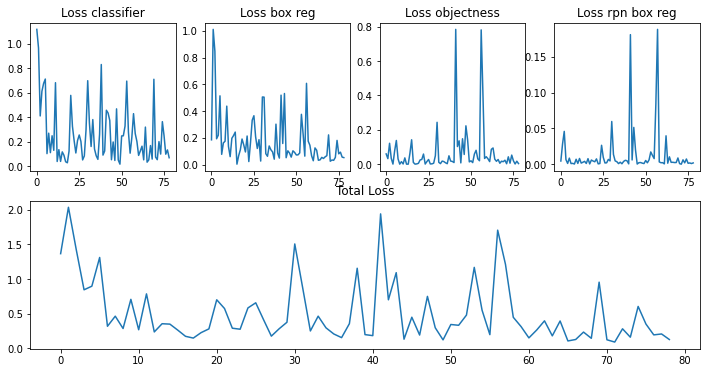

In [63]:
plot_loss_summary(l_losses,train_dataset.__len__(),num_epochs)

In [11]:
torchvision.models.detection.roi_heads

<module 'torchvision.models.detection.roi_heads' from 'C:\\Users\\diabo\\anaconda3\\lib\\site-packages\\torchvision\\models\\detection\\roi_heads.py'>

In [15]:
model.roi_heads.box_predictor 

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=5, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=20, bias=True)
)

In [57]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced', np.unique(validation_dataset.data['classes'].to_numpy()),validation_dataset.data['classes'].to_numpy())

In [58]:
class_weights = np.insert(class_weights, 0,np.mean(class_weights) )
AA_WEIGHTS_ZZ = torch.from_numpy(class_weights)
AA_WEIGHTS_ZZ = AA_WEIGHTS_ZZ.to(torch.float32)

In [59]:
AA_WEIGHTS_ZZ

tensor([ 8.7601, 30.5000,  0.4420,  0.7093,  3.3889])

In [56]:
class_weights

array([ 8.76005505, 30.5       ,  0.44202899,  0.70930233,  3.38888889])

In [47]:
torchvision.models.detection.roi_heads.fastrcnn_loss = fastrcnn_loss_rebranded

In [48]:
def fastrcnn_loss_rebranded(class_logits, box_regression, labels, regression_targets):
    # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    """
    Computes the loss for Faster R-CNN.
    Args:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)
    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    classification_loss = func.cross_entropy(class_logits, labels,weight = AA_WEIGHTS_ZZ)

    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

    box_loss = func.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        reduction='sum',
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

"''"